In [1]:
import warnings
warnings.filterwarnings('ignore')
# import sys
# sys.path.append('../')
# sys.path.append('/Users/nolansmyth/Code/SPISEA')
# sys.path.append('/Users/nolansmyth/Code/SPISEA/cdbs')
# sys.path.append('/Users/nolansmyth/Code/galaxia/galaxia/bin')

# %env PYTHONPATH=/Users/nolansmyth/Code/SPISEA/spisea
# %env PYSYN_CDBS=/Users/nolansmyth/Code/SPISEA/cdbs
# %env SPISEA_MODELS=/Users/nolansmyth/Code/SPISEA/
# import os
# os.environ["PATH"] = "/Users/nolansmyth/Code/galaxia/galaxia/bin:" + os.environ["PATH"]

from popsycle import synthetic
from popsycle import utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

%reload_ext autoreload
%autoreload 2

In [2]:
#Make obs_time and area small for testing
mock_roman_params = {"fdm": 1.0, 
                     "pbh_mass":30, 
                     "v_esc":550, 
                     "rho_0":0.0093, 
                     "r_s": 18.6, 
                     "r_max":16.6 , 
                     "gamma": 1.0, 
                    #  "obs_time":1825, 
                     "obs_time":18, 
                     "cadence":3, 
                     "blend_rad": 0.09, 
                     "longitude": 1.00, 
                     "latitude": -1.03, 
                    #  "area": 0.16,
                     "area": 0.0016,
                     "BH_kick_speed_mean": 100,
                     "NS_kick_speed_mean": 350
                     }

In additional to the usual python/astropy things, you'll need to install Galaxia, PyPopStar, PopSyCLE.
For PyPopStar, it goes faster once you've made isochrones.
Same goes from PopSyCLE with the initial-final cluster mass ratio file.

# Galaxia

This is where you generate the stellar model and set the survey direction and area.


Then create the stellar model, 
by running `galaxia -r galaxia_params.example.txt` on the command line. 
PopSyCLE can also combine these two steps by executing:


In [4]:
synthetic.run_galaxia(output_root = 'ffp',
                      longitude = mock_roman_params['longitude'],
                      latitude = mock_roman_params['latitude'],
                      area = mock_roman_params['area'],
                      galaxia_galaxy_model_filename='galaxyModelParams_Popsycle_roman_docker.txt')

** Generating ffp_galaxia_params.txt **
-- outputFile ffp
-- outputDir ./
-- photoSys UBV
-- magcolorNames V,B-V
-- appMagLimits[0] -1000
-- appMagLimits[1] 1000
-- absMagLimits[0] -1000
-- absMagLimits[1] 1000
-- colorLimits[0] -1000
-- colorLimits[1] 1000
-- geometryOption 1
-- longitude 1.000000
-- latitude -1.030000
-- surveyArea 0.00160
-- fSample 1
-- popID -1
-- warpFlareOn 1
-- seed 47
-- r_max 30
-- starType 0
-- photoError 0
** Executing Galaxia with ffp_galaxia_params.txt and galaxyModelParams_Popsycle_roman_docker.txt **
** STDOUT **
Reading Parameter file-             galaxyModelParams_Popsycle_roman_docker.txt
--------------------------------------------------------
GalaxiaData              /galaxia_models/GalaxiaData
bulge_Rc                 2.54                    
bulge_x0                 0.7                     
bulge_y0                 0.424                   
bulge_z0                 0.424                   
bulge_alpha              28                      
bulge_be

# Population Synthesis

The stellar model now needs compact objects, which we inject with PopSyCLE. 
This produces an .h5 file with both stars and compact objects, sorted by latitude and longitude.
Here you can set the black hole and neutron star kick speeds.

In [6]:
synthetic.perform_pop_syn(ebf_file = 'ffp.ebf', 
                          output_root = 'ffp',
                          iso_dir = '/galaxia_models/GalaxiaData/Isochrones/',
                          bin_edges_number = None, 
                          BH_kick_speed_mean = mock_roman_params['BH_kick_speed_mean'],
                          NS_kick_speed_mean = mock_roman_params['NS_kick_speed_mean'],
                          overwrite=True)

*********************** Starting popid 0
Starting age bin  5.8269758224487305
Starting sub-bin  0
Changing to logg=4.50 for T= 40284 logg=4.22
Changing to logg=4.50 for T= 41166 logg=4.21
Changing to logg=4.50 for T= 41489 logg=4.21
Changing to logg=4.50 for T= 41876 logg=4.21
Changing to logg=4.50 for T= 42337 logg=4.21
Changing to logg=4.50 for T= 42569 logg=4.21
Changing to logg=4.50 for T= 42812 logg=4.21
Changing to logg=4.50 for T= 43036 logg=4.21
Changing to logg=4.50 for T= 43235 logg=4.21
Changing to logg=4.50 for T= 43435 logg=4.21
Changing to logg=4.50 for T= 43640 logg=4.21
Changing to logg=4.50 for T= 43849 logg=4.20
Changing to logg=4.50 for T= 44060 logg=4.20
Changing to logg=4.50 for T= 44274 logg=4.20
Changing to logg=4.50 for T= 44493 logg=4.20
Changing to logg=4.50 for T= 44715 logg=4.20
Changing to logg=4.50 for T= 45056 logg=4.20
Changing to logg=4.50 for T= 45796 logg=4.20
Changing to logg=4.50 for T= 46562 logg=4.19
Changing to logg=4.50 for T= 47045 logg=4.19
Ch

AttributeError: 'IFMR' object has no attribute 'generate_death_mass'

### Add PBHs

In [5]:
#Most of these are default values, but want to show them all for clarity
synthetic.add_pbh('example.h5', 
                  'example.ebf', 
                  new_output_root='example_pbh', 
                  pbh_mass=mock_roman_params['pbh_mass'], 
                  fdm=mock_roman_params['fdm'],
                  v_esc = mock_roman_params['v_esc'],
                  rho_0=mock_roman_params['rho_0'],
                  r_s = mock_roman_params['r_s'], 
                  r_max = mock_roman_params['r_max'],
                  gamma=mock_roman_params['gamma'],)

Projected density along line-of-sight = 1.29e+09 [M_sun kpc**-2]
Mass within line-of-sight cylinder = 1.73e+07 [M_sun]
Number of PBH before and after light cone masking: 576901 and 150622, respectively
150622 PBHs in the field
- 0 PBHS removed from example.h5
--- 75440179 original objects
--- 150622 PBHs in the field
--- 75590801 new total objects
Binned PBHs equals total PBHs
add_pbh runtime: 53.363916 s


# Finding microlensing events

Here is when all microlensing events are found.
You can set the survey duration, cadence, maximum impact parameter, blend radius.
This also has the option of being parallelizable.

In [6]:
#Set to Roman Params from paper
synthetic.calc_events(hdf5_file = 'example_pbh.h5', 
                      output_root2 = 'example_pbh', 
                      radius_cut = 2,
                      obs_time = mock_roman_params["obs_time"], 
                      n_obs = int(mock_roman_params["obs_time"]/mock_roman_params["cadence"]), 
                      theta_frac = 2, 
                      blend_rad = mock_roman_params["blend_rad"], 
                      overwrite = True, 
                      n_proc = 7,) #adjust based on your number of cores

/Users/nolansmyth/opt/anaconda3/envs/popsycle/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/nolansmyth/Code/SPISEA/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/nolansmyth/opt/anaconda3/envs/popsycle/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/nolansmyth/Code/SPISEA/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/nolansmyth/opt/anaconda3/envs/popsycle/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/nolansmyth/Code/SPISEA/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/nolansmyth/opt/anaconda3/envs/popsycle/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/nolansmyth/Code/SPISEA/cdbs/extinction
  warnings.warn('Extinction files not

Working on loop ll, bb =  0 Working on loop ll, bb = Working on loop ll, bb =   310 22
 Working on loop ll, bb = Working on loop ll, bb = 
24 2 23
 
4 Working on loop ll, bb =  215 
20
Working on loop ll, bb =  0 25
Working on loop ll, bb =  1 25
Working on loop ll, bb =  0 1
Working on loop ll, bb =  1 0
Working on loop ll, bb =  2 24
Working on loop ll, bb =  2 0
Working on loop ll, bb =  0 2
Working on loop ll, bb =  2 25
Working on loop ll, bb =  1 1
Working on loop ll, bb =  3 0
Working on loop ll, bb =  2 1
Working on loop ll, bb =  0 3
Working on loop ll, bb =  3 1
Working on loop ll, bb =  2 2
Working on loop ll, bb =  0 4
Working on loop ll, bb =  3 2
Working on loop ll, bb =  2 3
Working on loop ll, bb =  1 2
Working on loop ll, bb =  0 5
Working on loop ll, bb =  1 3
Working on loop ll, bb =  2 4
Working on loop ll, bb =  0 6
Working on loop ll, bb =  3 3
Working on loop ll, bb =  1 4
Working on loop ll, bb =  0 7
Working on loop ll, bb =  0 8
Working on loop ll, bb =  1 5
W

# Photometry

This is the last thing, where you choose the photometric band for the observations and the reddening law.
The final file of microlensing events is produced here as a .fits file.

In [8]:
synthetic.refine_events(input_root = 'example_pbh', 
                        filter_name = 'I',
                        photometric_system = 'ubv',
                        red_law = 'Damineli16', 
                        overwrite = False, 
                        output_file = 'default')

Original candidate events:  24503
Candidate events in survey window:  23418
refine_events runtime : 32.611379 s


# Things you can do with PopSyCLE

First, read in the table, and print out a list of all the possible keys:

In [3]:
# t = Table.read('example_refined_events_i_Damineli16.fits')
t = Table.read('example_pbh_refined_events_ubv_I_Damineli16.fits')

print(t.colnames)

['zams_mass_L', 'mass_L', 'px_L', 'py_L', 'pz_L', 'vx_L', 'vy_L', 'vz_L', 'age_L', 'popid_L', 'exbv_L', 'glat_L', 'glon_L', 'mbol_L', 'grav_L', 'teff_L', 'feh_L', 'rad_L', 'rem_id_L', 'obj_id_L', 'ubv_J_L', 'ubv_H_L', 'ubv_K_L', 'ubv_U_L', 'ubv_I_L', 'ubv_B_L', 'ubv_V_L', 'ubv_R_L', 'vr_L', 'mu_b_L', 'mu_lcosb_L', 'zams_mass_S', 'mass_S', 'px_S', 'py_S', 'pz_S', 'vx_S', 'vy_S', 'vz_S', 'age_S', 'popid_S', 'exbv_S', 'glat_S', 'glon_S', 'mbol_S', 'grav_S', 'teff_S', 'feh_S', 'rad_S', 'rem_id_S', 'obj_id_S', 'ubv_J_S', 'ubv_H_S', 'ubv_K_S', 'ubv_U_S', 'ubv_I_S', 'ubv_B_S', 'ubv_V_S', 'ubv_R_S', 'vr_S', 'mu_b_S', 'mu_lcosb_S', 'theta_E', 'u0', 'mu_rel', 't0', 't_E', 'ubv_I_app_S', 'ubv_I_app_L', 'cent_glon_I_N', 'cent_glat_I_N', 'ubv_I_app_N', 'ubv_I_app_LSN', 'delta_m_I', 'f_blend_I', 'pi_rel', 'pi_E']


## Figure out how many events due to BH, NS, WD, star

In [4]:
pbh_idx = np.where(t['rem_id_L'] == 104)[0]
bh_idx = np.where(t['rem_id_L'] == 103)[0]
ns_idx = np.where(t['rem_id_L'] == 102)[0]
wd_idx = np.where(t['rem_id_L'] == 101)[0]
st_idx = np.where(t['rem_id_L'] == 0)[0]
print('Number of PBHs: ' + str(len(pbh_idx)))
print('Number of BHs: ' + str(len(bh_idx)))
print('Number of NSs: ' + str(len(ns_idx)))
print('Number of WDs: ' + str(len(wd_idx)))
print('Number of stars: ' + str(len(st_idx)))

Number of PBHs: 839
Number of BHs: 281
Number of NSs: 349
Number of WDs: 2580
Number of stars: 19369


## Histogram of tE

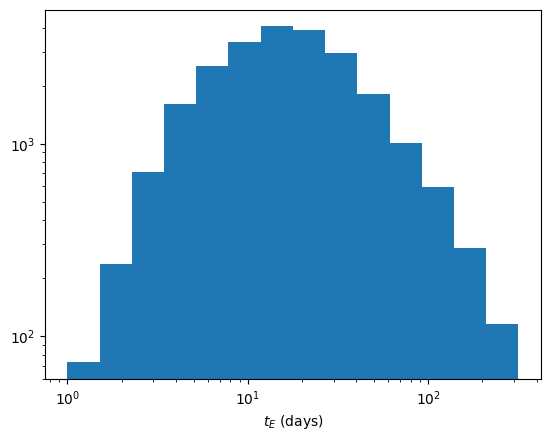

In [6]:
plt.hist(t['t_E'], bins = np.logspace(0, 2.5, 15))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.show()

## piE vs tE

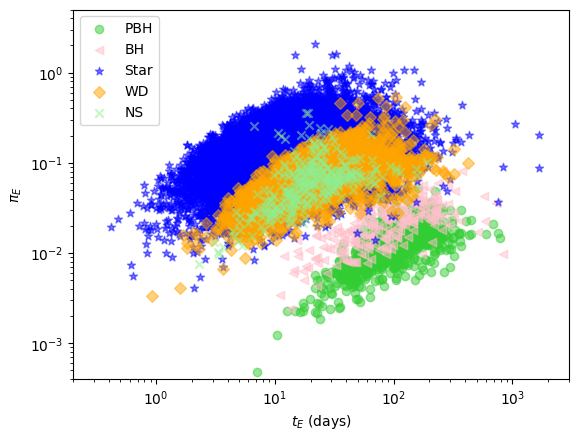

In [14]:
plt.scatter(t['t_E'][pbh_idx], t['pi_E'][pbh_idx], color = 'limegreen', marker='o', label = 'PBH', alpha=0.5)
plt.scatter(t['t_E'][bh_idx], t['pi_E'][bh_idx], color = 'pink', marker='<', label = 'BH', alpha=0.5)
plt.scatter(t['t_E'][st_idx], t['pi_E'][st_idx], color = 'blue', marker='*', label = 'Star', alpha=0.5)
plt.scatter(t['t_E'][wd_idx], t['pi_E'][wd_idx], color = 'orange', marker='D', label = 'WD', alpha=0.5)
plt.scatter(t['t_E'][ns_idx], t['pi_E'][ns_idx], color = 'lightgreen', marker='x', label = 'NS', alpha=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t_E$ (days)')
plt.ylabel('$\pi_E$')
plt.xlim(2e-1, 3e3)
plt.ylim(4e-4, 5e0)
plt.legend()
plt.show()

## dL vs dS

Text(0, 0.5, '$d_S$ (kpc)')

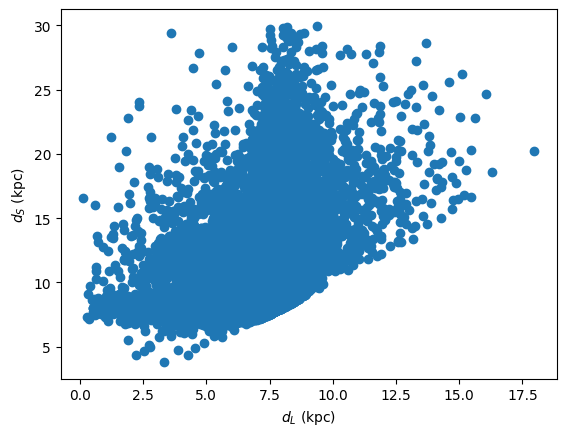

In [13]:
plt.scatter(t['rad_L'], t['rad_S'])
plt.xlabel('$d_L$ (kpc)')
plt.ylabel('$d_S$ (kpc)')